<h1 align="center">All relevant feature selection</h1>
<h2 align="center"> Is collinearity harmul? </h2>
<p style="text-align:center">
   Human Bender<br>
</p>

<div align="center">
    <img border="0" src="bender_hex_mini.png" width="100px" align="center" />
</div>




<h2 style="color:#deab02;">1 - Configuration, Loading the packages, data and utilities definition </h2>
 

First let's set the libraries, general settings and define some functions (in the notebook for convenience, will be moved in a library during a later stage).

## Packages

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
import catboost
from catboost import CatBoostRegressor, CatBoostClassifier
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
import arfs
import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.utils import highlight_tick, compare_varimp
from arfs.utils import load_data, sklearn_pimp_bench
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
gc.enable()
gc.collect()

26

<h2 style="color:#deab02;"> Simple Usage </h2>
If the dataset contains multicollinear features, the permutation importance will show that none of the features are important. This is obviously a drawback. Let's illustrate how the different ARFS methods deal with collinearity and if the performance depends on the kind of feature importance (native, shap, pimp). 

For comparison purpose, I reproduce below the [scikit-learn example](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py), with added random predictors (which should be filtered out).

I'll compare to the performance when collinear features are removed, using the pre-filters included in the package. When the filter finds collinear feature, it will keep one of them, randomly chosen, which is ok since it carries the same information than the others.

In [4]:
cancer = load_data(name='cancer')
X, y = cancer.data, cancer.target
# New instance of the class
fs = arfsfs.FeatureSelector(data = X, labels = y, weight = None)
# identify highly correlated columns (here corr_coef >= 0.75)
# set encode to True if there are categorical/string cols (takes a bit of time)
fs.identify_collinear(correlation_threshold=0.75, encode=False)
# tag the discarded predictors and store the results
fs_df = fs.tag_df
fs.ops['collinear']
# Plot and save the corr-map
heatmap = fs.plot_collinear(plot_all=True, size=300)
heatmap
# hv.save(heatmap, "C:User/my_folder/heatmap_corr.html")

Corr matrix done,    0 min and    0 min from start
19 features with a correlation magnitude greater than 0.75.



:HeatMap   [x,y]   (z)

In [5]:
X_filtered = fs.remove(methods=['collinear'])
X_filtered.head()

,mean radius,mean texture,mean smoothness,mean compactness,mean symmetry,mean fractal dimension,radius error,texture error,smoothness error,symmetry error,worst symmetry,random_num1,random_num2,genuine_num
0,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.03003,0.4601,0.496714,1,-0.270108
1,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01389,0.2750,-0.138264,1,0.076571
2,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.02250,0.3613,0.647689,1,0.183046
3,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.05963,0.6638,1.523030,3,-0.029524
4,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.01756,0.2364,-0.234153,0,-0.141723


## Sklearn permutation importance 

It suffers from the collinearity

==================== Benchmarking using sklearn permutation importance ====================


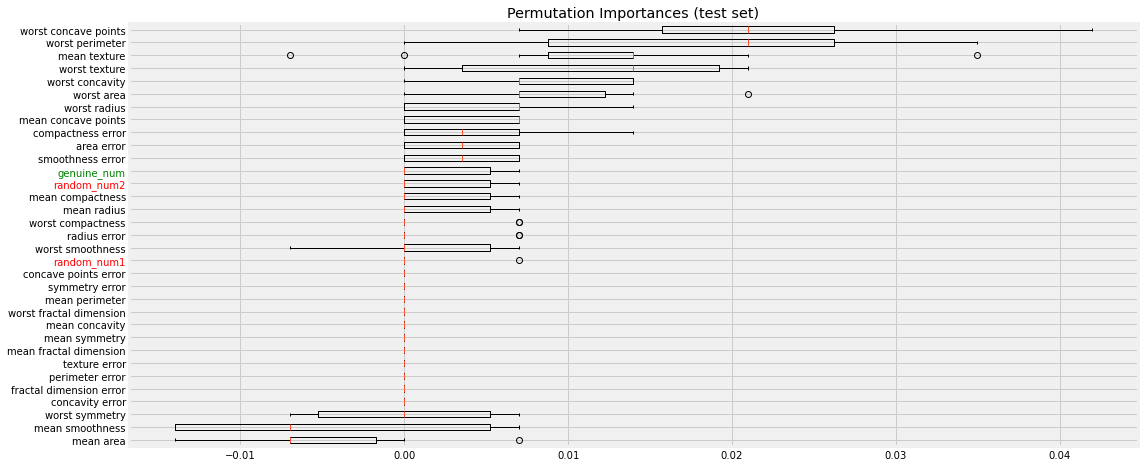

Wall time: 3 s


In [6]:
%%time
# Let's use lightgbm as booster, see below for using more models
model = LGBMClassifier(random_state=42, verbose=-1)
# Benchmark with scikit-learn permutation importance
print('=' * 20 + ' Benchmarking using sklearn permutation importance ' + '=' * 20)
fig = sklearn_pimp_bench(model, X, y, task='classification', sample_weight=None)

Let's repeat the permutation importance but with the collinear predictors filtered out.

==================== Benchmarking using sklearn permutation importance ====================


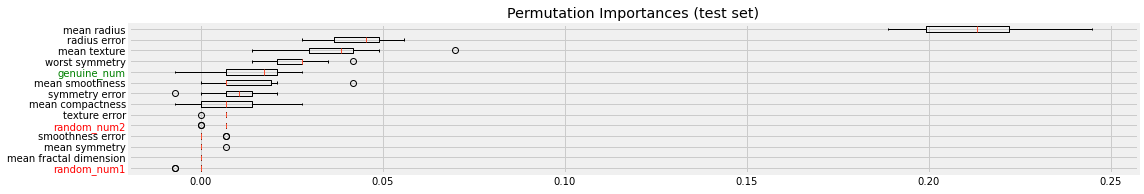

Wall time: 689 ms


In [7]:
%%time

# Benchmark with scikit-learn permutation importance
print('=' * 20 + ' Benchmarking using sklearn permutation importance ' + '=' * 20)
fig = sklearn_pimp_bench(model, X_filtered, y, task='classification', sample_weight=None)

The permutation importance performance looks much better when collinear predictors are filtered out.

## Leshy with permutation importance

Hereunder, I illustrate that the collinearity is problematic for the three methods of All Relevant Feature Selection. However the stability is greatly improved when the collinearity is handled.

Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:09<00:01,  1.07s/it]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	8
Rejected: 	13
All relevant predictors selected in 00:00:09.63
['worst texture', 'worst perimeter', 'worst concave points']


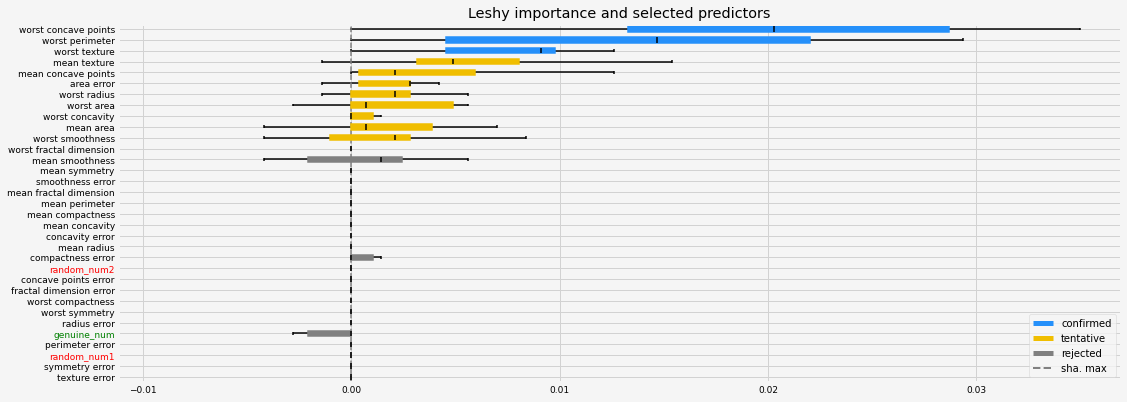

Wall time: 10.2 s


In [8]:
%%time
# Leshy, all the predictors, no-preprocessing
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='pimp')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

Same but collinear predictors filtered out

Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.31it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	4
Rejected: 	3
All relevant predictors selected in 00:00:03.90
['mean radius', 'mean texture', 'radius error', 'worst symmetry']


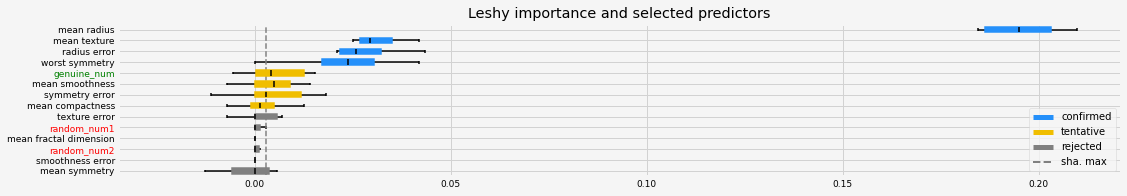

Wall time: 4.18 s


In [9]:
%%time
# Leshy, with collinearity handled
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='pimp')
feat_selector.fit(X_filtered, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## Does SHAP feature importance suffer from the collinearity?

SHAP is a linear feature importance attribution, the importance will be split between the collinear features.

### With all the predictors

Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  4.57it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	14
Tentative: 	2
Rejected: 	12
All relevant predictors selected in 00:00:01.98
['mean texture', 'mean area', 'mean smoothness', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry', 'genuine_num']


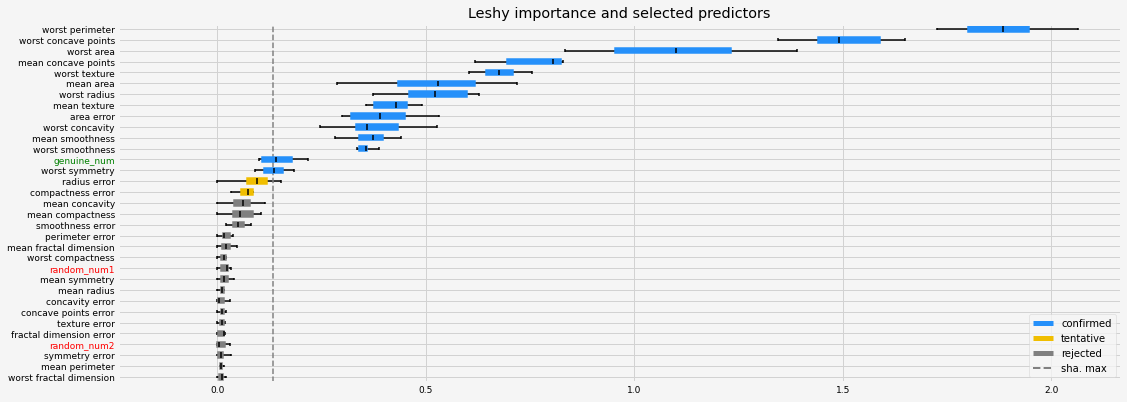

Wall time: 2.49 s


In [10]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

### With only the filtered predictors

Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  6.23it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	8
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:01.46
['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'radius error', 'symmetry error', 'worst symmetry', 'genuine_num']


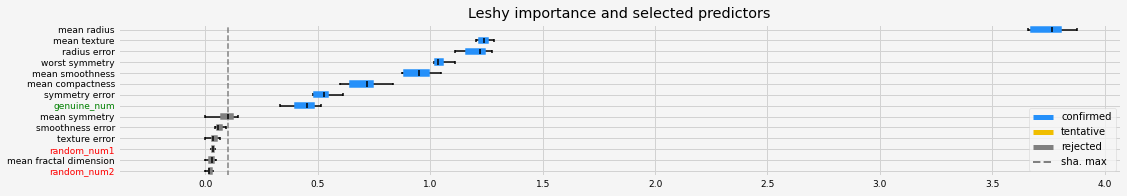

Wall time: 1.76 s


In [11]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='shap')
feat_selector.fit(X_filtered, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

There is indeed much less variability in the feature importance when the collinear predictors are filtered out.

## BoostAGroota

### All the predictors

BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:03<00:34,  3.82s/it]


0             mean texture
1                mean area
2          mean smoothness
3      mean concave points
4               area error
5             worst radius
6            worst texture
7          worst perimeter
8               worst area
9         worst smoothness
10         worst concavity
11    worst concave points
Name: feature, dtype: object


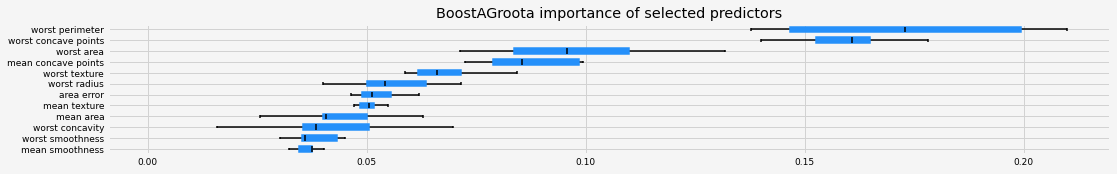

Wall time: 4.07 s


In [12]:
%%time
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, silent=True, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

### Filtered predictors

BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:03<00:29,  3.31s/it]

0         mean radius
1        mean texture
2     mean smoothness
3    mean compactness
4        radius error
5      symmetry error
6      worst symmetry
7         genuine_num
Name: feature, dtype: object


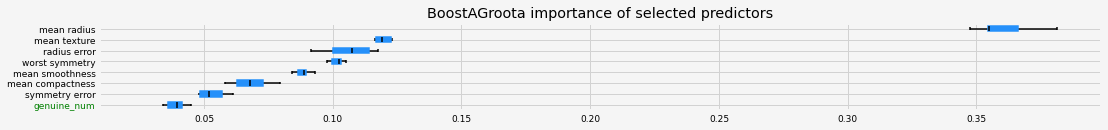

Wall time: 3.51 s


In [13]:
%%time
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, silent=True, importance='shap')
feat_selector.fit(X_filtered, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

Same conclusion than for Leshy, the variability is much smaller when the collinear predictors are filtered out.

## GrootCV

### All the predictors

Repeated k-fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.61it/s]


1             mean texture
7      mean concave points
13              area error
20            worst radius
21           worst texture
22         worst perimeter
23              worst area
24        worst smoothness
26         worst concavity
27    worst concave points
32             genuine_num
Name: feature, dtype: object


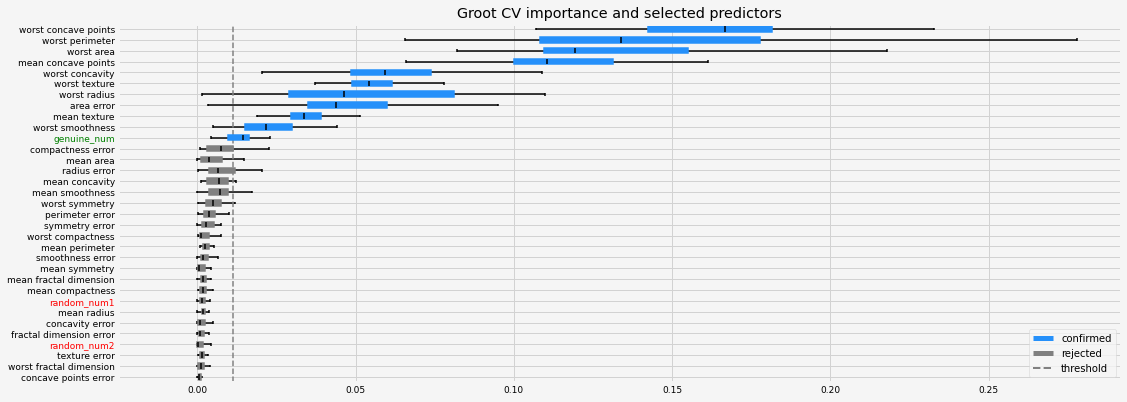

Wall time: 5.03 s


In [14]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='binary', cutoff = 1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

### Filtered predictors

Repeated k-fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.92it/s]


0          mean radius
1         mean texture
2      mean smoothness
3     mean compactness
6         radius error
9       symmetry error
10      worst symmetry
13         genuine_num
Name: feature, dtype: object


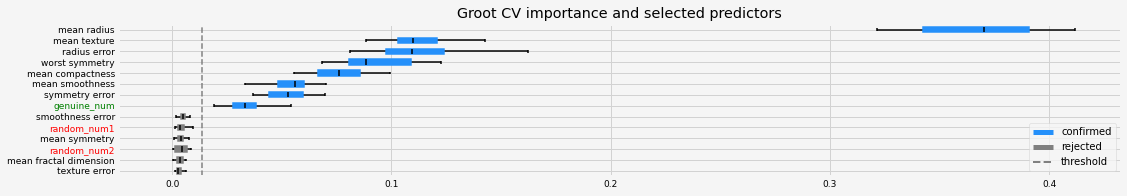

Wall time: 3.47 s


In [15]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='binary', cutoff = 1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X_filtered, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

With GrootCV, same conclusion as well: the variability is much smaller (smaller confidence interval) whe the collinear predictors are filtered out.